# Breast Cancer Image Classification Hierarchical Models Approach

The dataset Contatins breast images for normal, benign, and malignant breast cancers along with segmentation masks, 
after discarding the segmentation masks from training we have 445 benign , 220 malignant, 133 normal ultrasound images

**Since the data is highly unbalanced and we care to reduce false normal predictions, confusion matrix as well as F1 score will be our chosen metrics**

## Importing Modules

In [83]:
import numpy as np
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, make_scorer
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier


### We Binarize our problem to just predicting whether the image is normal or cancerous 

#### **We notice that unlike all usual datasets the normal is not the dominant class**

### General purpose preprocessing is done just resizing and normalization

In [84]:
#Reading Our data
image_directory = "C:\\Users\\zorof\\Downloads\\Dataset_BUSI\\Dataset_BUSI_with_GT\\"

In [85]:
#Function used to read the data and neglect the masked images
def load(image_folder, label_value):
    images = [img for img in os.listdir(image_directory + image_folder)]
    for i, image_name in enumerate(images):
        if "mask" in image_name:
            continue
        if image_name.split('.')[1] == 'png':
            image = cv2.imread(image_directory + image_folder + image_name)
            if image is not None:
                image = Image.fromarray(image)
                image = image.resize((SIZE, SIZE))
                image = np.array(image)


                dataset.append(image)
                label.append(label_value)
                if i == 266//2:
                    break

In [86]:
SIZE = 28
dataset = []
label = []
load('normal/', 0)
load('benign/', 1)  
load('malignant/', 2)
dataset = np.array(dataset)
label = np.array(label)

## Boosting a Decision tree Model with gradient boosting 

#### **The feature vectors are flattened to a (1, 28x28) vector and the data was split into 80~20 format with stratified sampling to ensure that the training and testing distributions are the same , random shuffling is also enabled**

#### **we trained an gradient boosting algorithm with a 100 decision tree model as a weak learners that are regularized with a learning rate of 0.1**

In [87]:
gbm_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

In [88]:
# Data Splitting
num_samples, height, width, channels = dataset.shape
X_flat = dataset.reshape(num_samples, -1)
X_train, X_test, y_train, y_test = train_test_split(X_flat, label, test_size=0.1, random_state=42, stratify=label, shuffle=True)

In [89]:
# Cross-validation
# Define a 10-fold cross-validation strategy with shuffling.
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Use the F1 score as the evaluation metric.
scorer = make_scorer(f1_score)

# Perform cross-validation on the Gradient Boosting model.
scores = cross_val_score(gbm_model, X_train, (y_train > 0), cv=kf, scoring=scorer)

# Calculate the mean F1 score across all folds.
mean_f1_score = np.mean(scores)

print("Mean F1 Score:", mean_f1_score)

Mean F1 Score: 0.847422561478792


In [90]:
# Fit the model and make predctions
gbm_model.fit(X_train, (y_train > 0).astype(int))
# y_pred = gbm_model.predict(X_test)

GradientBoostingClassifier(random_state=42)

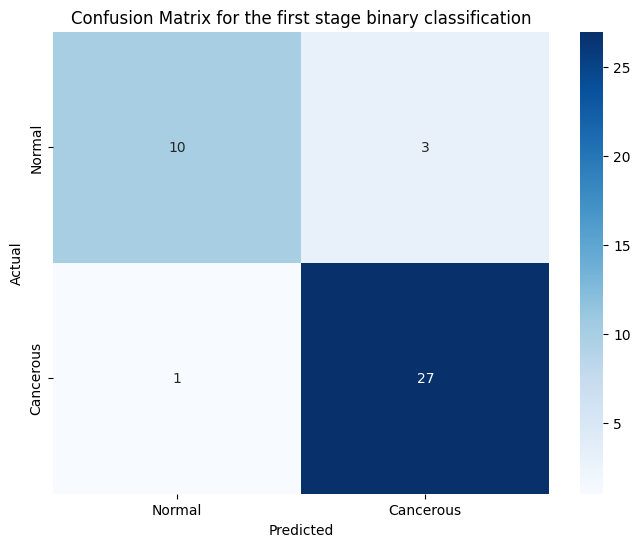

In [91]:
y_pred = gbm_model.predict(X_test)
cm = confusion_matrix((y_test > 0).astype(int), y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Cancerous'],
            yticklabels=['Normal', 'Cancerous'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for the first stage binary classification')
plt.show()

### The F1-Score is better compared to score from adaptive boosting approache

In [92]:
tn, fp, fn, tp = cm.ravel()
# Calculating the false negative rate
fnr = fn / (fn + tp)
fnr_percentage = fnr * 100
print("False Negative Rate: {:.2f}%".format(fnr_percentage))

False Negative Rate: 3.57%


In [93]:
accuracy_score((y_test > 0).astype(int), y_pred)

0.9024390243902439

### Now Classifying Benign versus Malignant

### Boosting a Decision tree Model with gradient boosting for the second task

#### **Using the same setup for the first stage for gradient boost and logistic regression also yeild acceptable F1-Score results**

In [94]:
gbm_model_2 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

In [95]:
mask = ~(y_train==0)

In [96]:
# Cross-validation
# Define a 10-fold cross-validation strategy with shuffling.
kf = KFold(n_splits=10, shuffle=True, random_state=42)

scorer = make_scorer(f1_score)
scores = cross_val_score(gbm_model_2, X_train[mask], ((y_train[mask]-1)>0).astype(int), cv=kf, scoring=scorer)
mean_f1_score = np.mean(scores)
print("Mean F1 Score:", mean_f1_score)

Mean F1 Score: 0.867495863989132


In [97]:
# Fit the model
gbm_model_2.fit(X_train[mask], y_train[mask])
# y_pred = gbm_model_2.predict(X_test)

GradientBoostingClassifier(random_state=42)

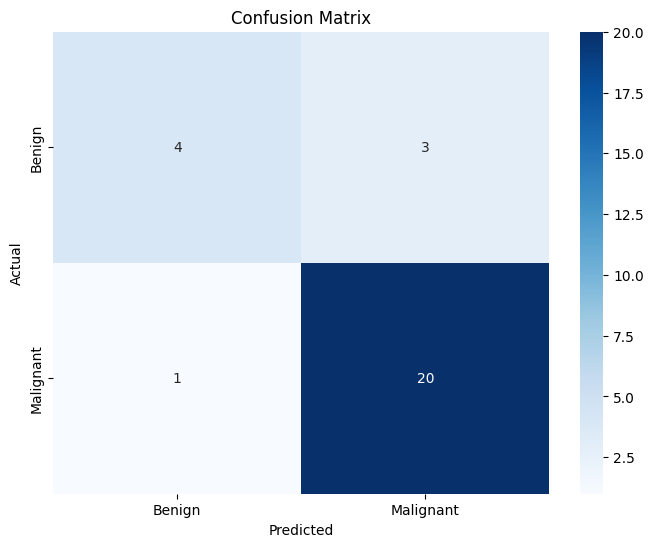

In [98]:
cm = confusion_matrix(y_test[~(y_test==0)], gbm_model_2.predict(X_test[~(y_test==0)]))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Merging the whole hierarchical model

In [99]:
y_test_pred=[]

In [100]:
#Function for making predictions
def make_pred(instance):
    normal_or_cancer = gbm_model.predict(instance) # First stage, check for normal or cancerous
    if normal_or_cancer == 0:
        return 0
    cancer_type = 2 if gbm_model_2.predict(instance) else 1 # Second stage, if cancerous check for benign or malignant
    return cancer_type

In [101]:
# Make predictions for X_test 
for img in X_test:
    y_test_pred.append(make_pred(img.reshape(1, -1)))

In [102]:
# Make predictions for X_train
y_pred_1=[]
for img in X_train:
    y_pred_1.append(make_pred(img.reshape(1, -1)))
# Get accuracy
f1_score(y_train, y_pred_1, average="weighted")

0.7672346586479564

In [103]:
# Get Test Accuracy
f1_score(y_test, y_test_pred, average="weighted")

0.6860353897656624

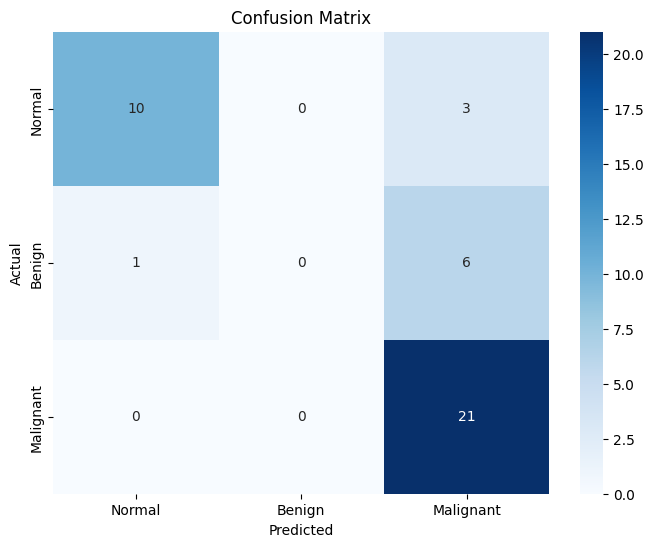

In [104]:
# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Benign', 'Malignant'],
            yticklabels=['Normal', 'Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## We Notice that there is no dangerous case ,there is no false normal prediction

Notes:
* There is a potential overfitting from looking into the results for each training stage F1-Score of 100%, we tried regularization parameter C for Logistic Regression but it did not imporve the results.
* PCA linear Dimentionallity reduction was observed with keeping 0.75, 0.85, 0.95 explained variance but it did not improve the results.
* Bagging Models Like Random Forests also did not improve the results moreover it showed tendency to bias towards the most abundant class.
* Anomaly detection approach was observed using One Class SVM and it did not improve the results as well.
* SVMs showed higher variance even when regularized.
* Hand Crafted Features like HOGs, MOPs, SIFT and Harris where observed and showed results no more than 55% F1-Score
* The Hierarchical Approach seems to reduce the overfitting problem a bit.
* Each model in the hierarchy is treated as a seperate model which is trained and evaluated on its own kfold cross validation

Possbile Future Work:
*     Extracting Meaningfull features using CNN based models.
*     Trying similarity learning rather than a discriminating function some siamise archticture style.
*     Using Generalized Hough transform to search for objects